In [2]:
# CNN 베이스모델
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
# 목차
# 1. 베이스 모델 구현 및 실행
# 2. 데이터 augment 구현
# 3. 구현된 데이터를 사용한 베이스 모델 실행 및 비교
# 4. 모델 구조 조정 및 실행을 통한 베이스 모델과의 성능 비교
# 5. ResNet-18 모델 구현 및 학습
# 6. 회고

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
# 파일 불러오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
# 경로 내 이미지 파일 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# 데이터셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
# 훈련용, 검증용 데이터셋 분기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

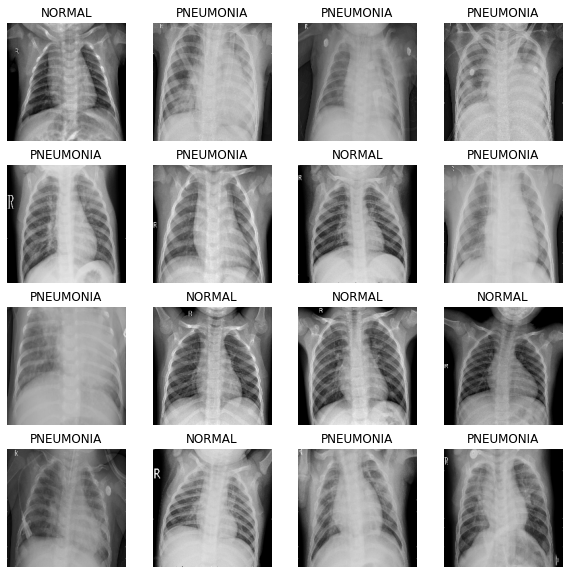

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [20]:
# 데이터 불균형 보정
# 수가 적은 클래스에 높은 가중치를 부여함
# >> 음성 이미지에 높은 가중치
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 204ms/step - loss: 0.4408 - accuracy: 0.7893 - precision: 0.9470 - recall: 0.7593 - val_loss: 0.5992 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2827 - accuracy: 0.8860 - precision: 0.9707 - recall: 0.8735 - val_loss: 0.9710 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 202ms/step - loss: 0.2530 - accuracy: 0.9001 - precision: 0.9715 - recall: 0.8916 - val_loss: 0.7034 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.2072 - accuracy: 0.9191 - precision: 0.9789 - recall: 0.9108 - val_loss: 0.1723 - val_accuracy: 0.9260 - val_precision: 0.9858 - val_recall: 0.9121
Epoch 5/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1852 - accura

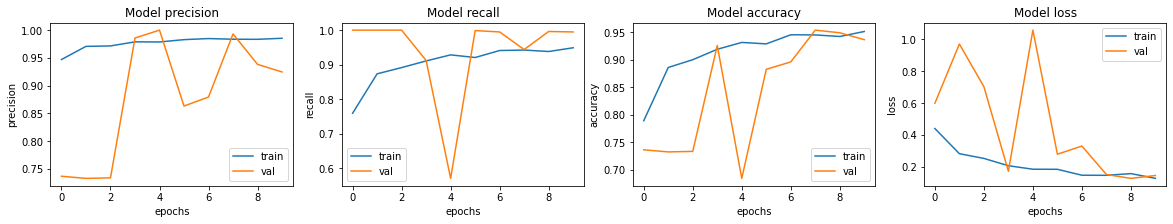

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 1.1485 - accuracy: 0.6971 - precision: 0.6736 - recall: 1.0000
Loss: 1.1485352516174316,
Accuracy: 0.6971153616905212,
Precision: 0.6735751032829285,
Recall: 1.0


In [ ]:
# 베이스 모델을 여러 번 에포크 시도한 결과
# recall값이 0.7에서 1.0까지도 출력되었으나 precision이 이에 따라 반비례하는 양상을 확인함
# 데이터셋에서 양성 데이터의 비중을 높였음에도 모델이 negative를 분류하는 성능이 크게 떨어짐

In [26]:
# 폐렴 진단기 성능 개선을 위한 이미지 좌우 반전 augmentation

# 이전 입력값의 차원 확인
image_batch[0].shape

TensorShape([180, 180, 3])

In [29]:
# 파일 데이터셋 이름 설정
# 각각 파일의 이름 리스트
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [45]:
# 이미지 좌우 반전
# label은 그대로 반환됨
# 의료용이므로 노이즈를 줄이기 위해 회전이나 shift 등은 사용하지 않음
def augment(image):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image

In [46]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [47]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)
    image = tf.io.read_file(file_path)
    image = decode_image(image)
    return image, label

In [48]:
# augment를 포함한 함수 적용
def process_path_for_train(file_path):
    label = get_label(file_path)
    image = tf.io.read_file(file_path)
    image = decode_image(image)
    image = augment(image)
    return image, label

In [49]:
# 파일 경로에 함수를 적용하여 이미지와 레이블 불러오기
train_ds = train_list_ds.map(process_path_for_train, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [50]:
# label이 bool type임 : false = 0
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [51]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [52]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

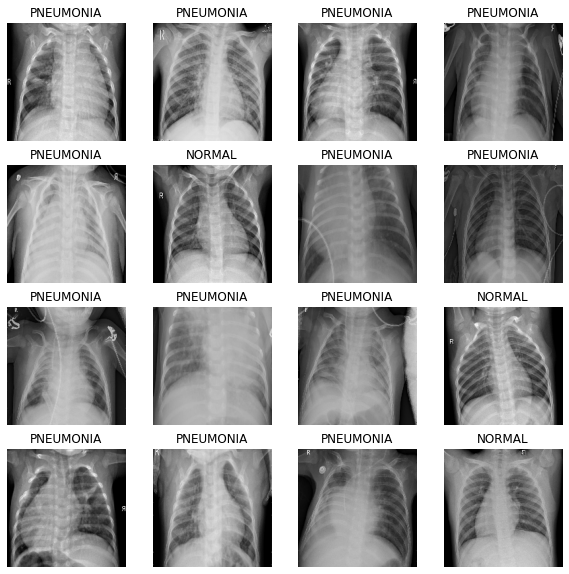

In [53]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# label_batch를 int 타입으로 변환함
image_batch, label_batch = next(iter(train_ds))
label_batch = tf.cast(label_batch, tf.int32)
show_batch(image_batch.numpy(), label_batch.numpy())

In [57]:
label_batch.dtype

tf.int32

In [54]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# with 블록 안에서 작업을 수행하고, 블록을 벗어나면 컨텍스트 관리자가 자동으로 정리 작업을 수행함
# 특정 디바이스를 설정할 때 with tf.device()를 사용하면 블록 내부에서 정의된 모든 연산을 해당 디바이스에서 실행함
# 블록을 벗어나면 디바이스 설정이 해제됨

In [55]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 203ms/step - loss: 0.4263 - accuracy: 0.8046 - precision: 0.9421 - recall: 0.7857 - val_loss: 0.6287 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2529 - accuracy: 0.8949 - precision: 0.9681 - recall: 0.8881 - val_loss: 0.7615 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2217 - accuracy: 0.9207 - precision: 0.9780 - recall: 0.9141 - val_loss: 0.3952 - val_accuracy: 0.8202 - val_precision: 0.8030 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 198ms/step - loss: 0.1823 - accuracy: 0.9298 - precision: 0.9786 - recall: 0.9260 - val_loss: 0.2425 - val_accuracy: 0.9000 - val_precision: 0.9985 - val_recall: 0.8650
Epoch 5/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1616 - accura

39/39 [==============================] - 4s 105ms/step - loss: 1.5652 - accuracy: 0.6378 - precision: 0.6331 - recall: 1.0000
Loss: 1.5651549100875854,
Accuracy: 0.6378205418586731,
Precision: 0.6331169009208679,
Recall: 1.0


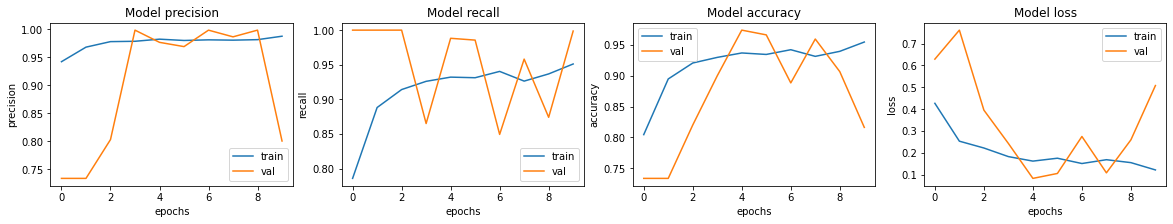

In [58]:
# 그래프 출력
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
# 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능 비교
# 이전
# Loss: 1.1485352516174316,
# Accuracy: 0.6971153616905212,
# Precision: 0.6735751032829285,
# Recall: 1.0

# # 이후
# Loss: 1.5651549100875854,
# Accuracy: 0.6378205418586731,
# Precision: 0.6331169009208679,
# Recall: 1.0

# 아래에서 그래프로 출력하였음

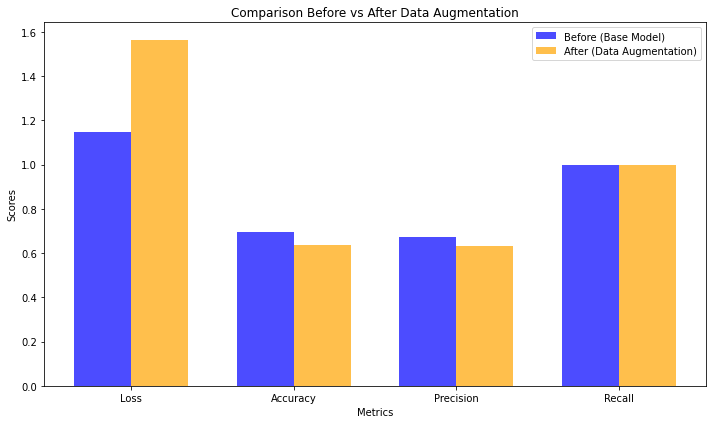

In [60]:
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']
before = [1.1485, 0.6971, 0.6735, 1.0]  # 이전
after = [1.5651, 0.6378, 0.6331, 1.0]   # 이후

x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# 이전
rects1 = ax.bar(x - width/2, before, width, label='Before (Base Model)', color='blue', alpha=0.7)
# 이후
rects2 = ax.bar(x + width/2, after, width, label='After (Data Augmentation)', color='orange', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison Before vs After Data Augmentation')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 그래프 상 큰 차이가 나타나지 않았고, 두 경우 모두 recall값이 1.0에 근접하였음
# acc와 precision이 모두 낮게 형성되어있기 때문에 모델의 예측 성능이 개선되지 않았음
# 즉, 데이터들에 대해 positive로 오분류하는 확률이 높음

In [ ]:
# 모델의 구조 변경 + Augment 데이터

In [64]:
# filter 크기 조정
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 6, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 6, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [65]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
# 이미지 사이즈 : 180 *180

In [66]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        # 출력수 조정
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(256, 0.5),
        dense_block(128, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [67]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [68]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 205ms/step - loss: 0.5783 - accuracy: 0.7100 - precision: 0.8951 - recall: 0.6916 - val_loss: 0.6016 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 201ms/step - loss: 0.3846 - accuracy: 0.8283 - precision: 0.9456 - recall: 0.8162 - val_loss: 0.6009 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.3613 - accuracy: 0.8551 - precision: 0.9402 - recall: 0.8600 - val_loss: 0.1986 - val_accuracy: 0.9212 - val_precision: 0.9595 - val_recall: 0.9318
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2456 - accuracy: 0.9021 - precision: 0.9691 - recall: 0.8970 - val_loss: 0.3410 - val_accuracy: 0.8817 - val_precision: 0.9748 - val_recall: 0.8613
Epoch 5/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1959 - accura

39/39 [==============================] - 4s 113ms/step - loss: 0.6104 - accuracy: 0.8173 - precision: 0.7816 - recall: 0.9821
Loss: 0.6104180216789246,
Accuracy: 0.817307710647583,
Precision: 0.781632661819458,
Recall: 0.9820512533187866


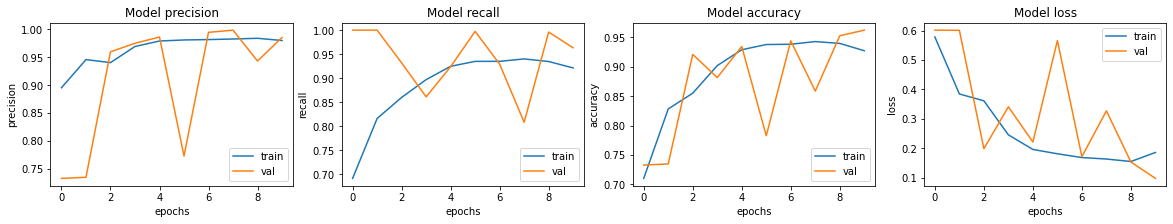

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

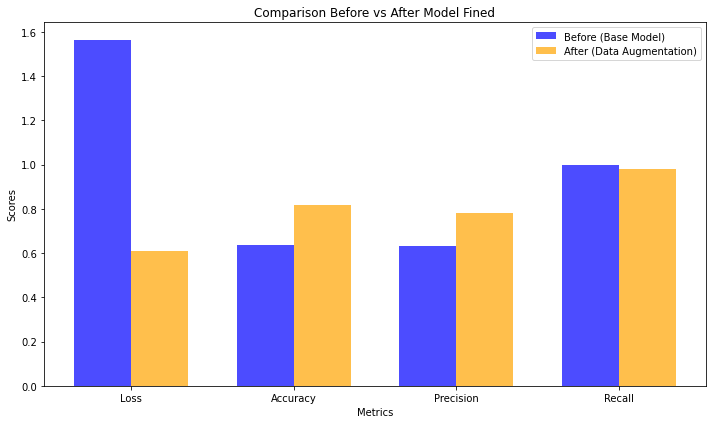

In [71]:
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']
before = [1.5651, 0.6378, 0.6331, 1.0]  # 베이스 모델
after = [0.6104, 0.8173, 0.7816, 0.9820]   # fined 모델

x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# 이전
rects1 = ax.bar(x - width/2, before, width, label='Before (Base Model)', color='blue', alpha=0.7)
# 이후
rects2 = ax.bar(x + width/2, after, width, label='After (Data Augmentation)', color='orange', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison Before vs After Model Fined')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 베이스모델에 대한 세부 조정 결과로 accuracy와 precision이 적지 않게 증가하였음

In [ ]:
# ResNet-18 모델 구현하기

In [124]:
# Residual block 구성하기
import tensorflow as tf

def resnet_block(x, filters, strides=1):
    shortcut = x
    
    x = tf.keras.layers.Conv2D(filters, 3, strides = strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters, 3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    if strides != 1 or shortcut.shape[-1] != filters: 
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size = (1, 1), strides = strides, padding = 'same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
# stride 값이 1이 아니거나, shortcut 경로의 채널수가 현재 레이어의 필터 수와 다를 경우
# shortcut 경로를 조정함
# 1*1 컨볼루션으로 채널 수를 조정함 >> filters의 숫자만큼 채널수를 맞춤
# 배치 정규화를 사용하여 학습 안정 및 가속
        
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [132]:
# resnet 정의
# 필터 개수를 줄여서 적용하였음 

def resnet_18():
    input_layer = tf.keras.layers.Input(shape = (180, 180, 3))
    
    x = tf.keras.layers.Conv2D(16, kernel_size = (7, 7), strides = (2, 2), padding = 'same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same')(x)
    
    x = resnet_block(x, 32)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, strides=2)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = tf.keras.layers.AveragePooling2D(pool_size = (6, 6), strides = (1, 1))(x)

    # 이진 분류이므로 sigmoid로 적용함
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)

    model = tf.keras.Model(inputs = input_layer, outputs = x)
    return model

In [133]:
with tf.device('/GPU:0'):
    model = resnet_18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# softmax로 출력시 손실함수를 수정해야 함
# 레이블과 출력함수의 차원이 달랐음

In [134]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 62s 195ms/step - loss: 0.2588 - accuracy: 0.8942 - precision: 0.9641 - recall: 0.8909 - val_loss: 5.2172 - val_accuracy: 0.2788 - val_precision: 1.0000 - val_recall: 0.0196
Epoch 2/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1430 - accuracy: 0.9425 - precision: 0.9822 - recall: 0.9399 - val_loss: 0.6724 - val_accuracy: 0.7212 - val_precision: 1.0000 - val_recall: 0.6194
Epoch 3/10
261/261 [==============================] - 51s 196ms/step - loss: 0.1239 - accuracy: 0.9523 - precision: 0.9866 - recall: 0.9488 - val_loss: 6.8778 - val_accuracy: 0.2865 - val_precision: 1.0000 - val_recall: 0.0262
Epoch 4/10
261/261 [==============================] - 52s 198ms/step - loss: 0.0993 - accuracy: 0.9588 - precision: 0.9893 - recall: 0.9550 - val_loss: 7.7142 - val_accuracy: 0.2769 - val_precision: 1.0000 - val_recall: 0.0131
Epoch 5/10
261/261 [==============================] - 53s 202ms/step - loss: 0.0863 - accura

39/39 [==============================] - 5s 121ms/step - loss: 0.5622 - accuracy: 0.8189 - precision: 0.9235 - recall: 0.7744
Loss: 0.5621519684791565,
Accuracy: 0.8189102411270142,
Precision: 0.9235473871231079,
Recall: 0.7743589878082275


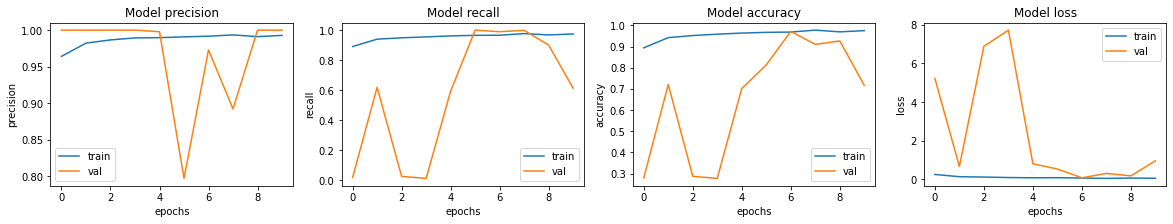

In [135]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

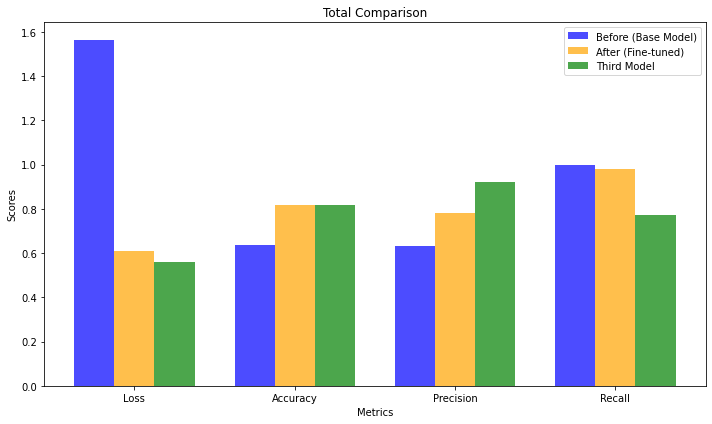

In [136]:
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']

before = [1.5651, 0.6378, 0.6331, 1.0]    # 베이스 모델
after = [0.6104, 0.8173, 0.7816, 0.9820]  # Fine-tuned 모델
third = [0.5621, 0.8189, 0.9235, 0.7743]  # ResNet 모델

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, before, width, label='Before (Base Model)', color='blue', alpha=0.7)
rects2 = ax.bar(x, after, width, label='After (Fine-tuned)', color='orange', alpha=0.7)
rects3 = ax.bar(x + width, third, width, label='Third Model', color='green', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Total Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# resnet block과 resnet 층 모델 구현의 난이도가 높았음
# 다양한 에러코드들을 마주하며 수정하는 과정이 시간을 많이 소요하였으나 도움이 되었음
# TypeError: resnet_block() got multiple values for argument 'strides'
# >> 함수 호출 과정에서 인자를 잘못 설정함
# ValueError: Negative dimension size caused by subtracting 7 from 6
# >> 풀링 크기가 7인데 입력 크기가 6이었음
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
# >> 레이블은 0 또는 1의 스칼라 형태인데 출력층을 뉴런 2의 소프트맥스로 적용했다가 발생한 오류
# >> 출력 함수를 시그모이드로 설정해서 해결함

# 전체적으로 그래프가 요동치고 학습이 불안정한 양상을 띠었으므로 데이터 단위에서부터 재설정이 필요하다고 판단되었음
# 다시 시도해본다면 이미지 해상도를 조금 더 높게 설정해보고싶음

# 참고
# https://wjunsea.tistory.com/99 (ResNet 구조 이해 및 구현)
# https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras/notebook
# https://velog.io/@stilltravel/AI-ResNet-18-Layer